In [1]:
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
import pandas as pd
import numpy as np

In [4]:
# 1. Data Load
print("Loading Data...")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print ("Data is loaded!")

Loading Data...
Data is loaded!


In [5]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [ ]:
quantitative

In [ ]:
qualitative

<Axes: >

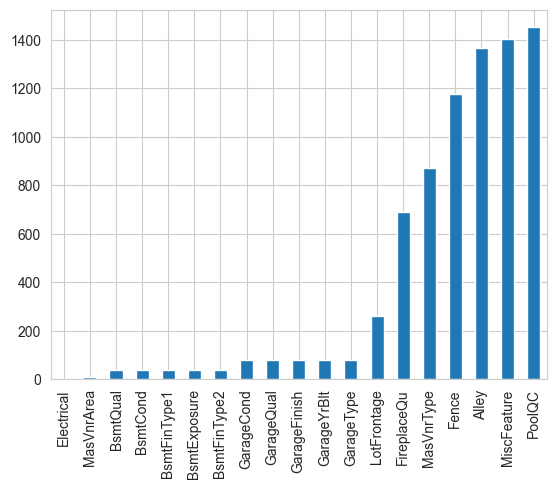

In [9]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

/var/folders/xy/y2__5y4x7_9_6z7svr2lxkkr0000gn/T/ipykernel_6053/3354568662.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/var/folders/xy/y2__5y4x7_9_6z7svr2lxkkr0000gn/T/ipykernel_6053/3354568662.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

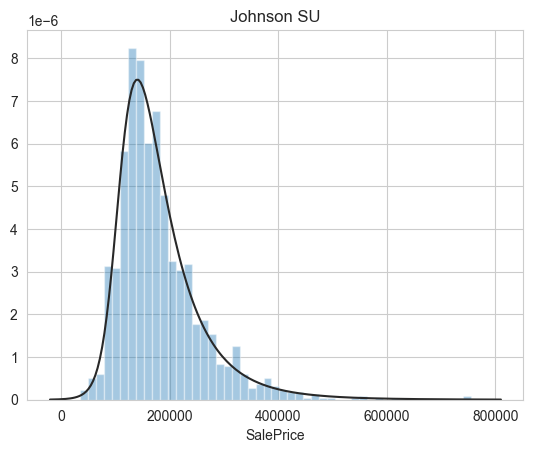

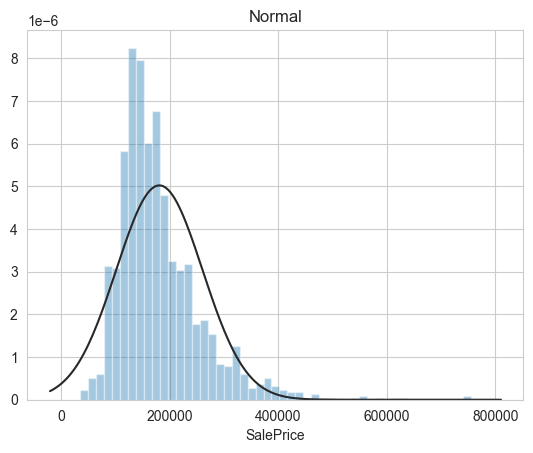

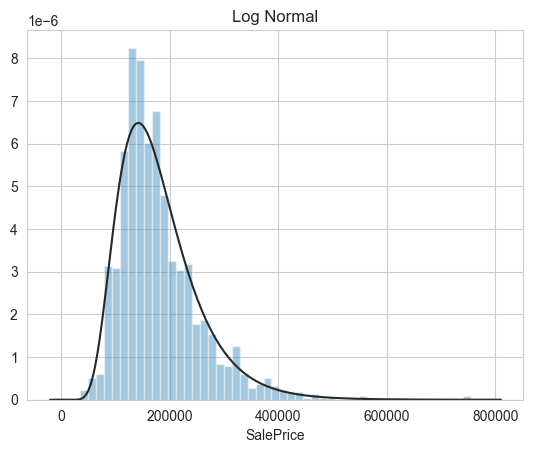

In [10]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [11]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [14]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

In [15]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [16]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [18]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [19]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/opt/anaconda3/envs/my-projects/lib/python3.13/site-packages/scipy/stats/_morestats.py:1340: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [20]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [22]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [23]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 333)

In [24]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 333), (1458,), (1459, 333))

In [25]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [26]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [27]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [34]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=int(1e7), alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [35]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)    

In [36]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [37]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [38]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [40]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1025 (0.0147)
 2025-02-06 15:22:26.462231
elastic net: 0.1027 (0.0149)
 2025-02-06 15:23:21.519706
SVR: 0.1597 (0.0225)
 2025-02-06 15:23:26.286022
lightgbm: 0.1062 (0.0159)
 2025-02-06 15:24:32.519706
gbr: 0.1068 (0.0149)
 2025-02-06 15:26:13.162016


In [42]:
print('START Fit')

# print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
elasticnet
Lasso
Ridge
Svr
GradientBoosting
lightgbm


In [ ]:
# # 2. Data Inspection
# print("\nData Inspection...")
# print("Train Data Shape:", data.shape)
# print("Test Data Shape:", test_data.shape)
# print("\nFirst 5 rows of the dataset:")
# print(data.head())
# print("\nMissing Values:")
# print(data.isnull().sum())
# print("\nSummary Statistics:")
# print(data.describe())

In [ ]:
# # 3. Data Analysis
# print("\nData Analysis...")
# sns.histplot(data['target'], kde=True)  # Replace 'target' with the actual target column
# plt.title("Target Distribution")
# plt.show()

# sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title("Feature Correlation Matrix")
# plt.show()

In [ ]:
# # 4. Model Training
# print("\nModel Training...")
# X = data.drop(columns=['target'])  # Replace 'target' with actual target column
# y = data['target']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

In [ ]:
# 5. Model Evaluation
# print("\nModel Evaluation...")
# y_pred = model.predict(X_val)
# print("Accuracy Score:", accuracy_score(y_val, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred))